In [2]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

%matplotlib inline

In [3]:
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter
from tenpy.networks.site import SpinHalfSite

__all__ = ['TFIModel', 'TFIChain']


class TFIModel(CouplingMPOModel):

    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', 'parity', self.name)
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinHalfSite(conserve=conserve)
        return site

    def init_terms(self, model_params):
        J = get_parameter(model_params, 'J', 1., self.name, True)
        g = get_parameter(model_params, 'g', 1., self.name, True)
        perturbation = get_parameter(model_params, 'perturbation', False, self.name, False)
        p_strength = get_parameter(model_params, 'p_strength', 0.001, self.name, False)        
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-g, u, 'Sigmaz')
        if perturbation == True:
            for u in range(len(self.lat.unit_cell)):
                self.add_onsite(p_strength, u, 'Sigmax')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-J, u1, 'Sigmax', u2, 'Sigmax', dx)

class TFIChain(TFIModel, NearestNeighborModel):

    def __init__(self, model_params):
        model_params.setdefault('lattice', "Chain")
        CouplingMPOModel.__init__(self, model_params)
        
        
def DMRG_TFI(L, g, chi_max = 30, verbose=0, bc = 'infinite', perturbation=False, p_strength=0, two='True'):
    
    '''DMRG in the Transverse field Ising model finite/infinite 1D chain'''
    
    model_params = dict(L=L, J=1., g=g, bc_MPS=bc, conserve=None, verbose=verbose, perturbation=perturbation, p_strength=p_strength)
    M = TFIChain(model_params)
    psi = MPS.from_product_state(M.lat.mps_sites(), ["up"] * M.lat.N_sites, bc=M.lat.bc_MPS)
    dmrg_params = {
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10
        },
        'lanczos_params' : {"reortho" : True},
        'max_E_err': 1.e-10,
        'verbose': 0
    }
    
    if two == True:
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        E, psi = eng.run()
    else:
        dmrg.run(psi, M, dmrg_params)
        E = np.sum(psi.expectation_value(M.H_bond[1:]))    
    
    return M, E, psi

def magnetization(psi):

    '''Computation of the magnetization of an MPS state'''
    
    M = np.sum(psi.expectation_value("Sigmax"))/psi.L  
    
    return M

def absolute_magnetization(psi):

    '''Computation of the expectation value of the squared magnetization of an MPS state'''
    
    M = np.sum(psi.correlation_function("Sigmax", "Sigmax"))/psi.L**2  

    return M


def add_local_operator(name, operator, psi):
    
    '''Add an operator to a MPS. Just adds it to one site, then it copies to all of them'''
    
    psi.sites[0].add_op(name, operator)
    
    return psi

In [ ]:
def Mag(L): 
    '''
     Magnetization operator (Numpy array)
    '''
    sz=np.array([[1,0],[0,-1]])
    M=np.zeros((2**L,2**L))
    for i in range(L):
        M=M+NKron(L,sz,np.eye(2),i)
    return M/L

L = 5
g_list = np.logspace(-2,2,10)
M_list = M_list_wf = []
psi_list = wf_list = []
for g in g_list:

    M, E, psi = DMRG_TFI(L, g, verbose=False, chi_max = 30, bc = 'finite', perturbation = True, p_strength=-0.01, two=True)
    psi_list = np.append(psi_list, psi)
    M_list = np.append(M_list, magnetization(psi))
    wf = psi.get_theta(0,L).to_ndarray().reshape(-1)
    wf_list.append(wf)
    M_list_wf = np.append(M_list_wf, np.conjugate(wf).T@Mag(L)@wf)

/home/joana/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


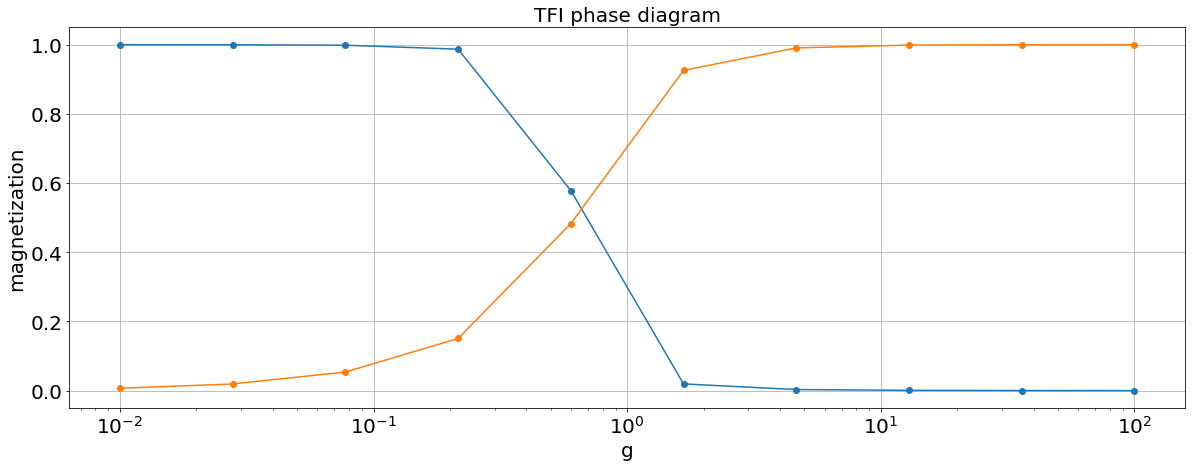

In [31]:
fig = plt.figure(figsize=(20,7))
plt.title('TFI phase diagram', fontsize = 20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.ylabel('magnetization', fontsize=20)
plt.xlabel('g', fontsize=20)
plt.grid(axis='both')
plt.plot(g_list, M_list, 'o-')
plt.plot(g_list, M_list_wf, 'o-')
plt.xscale("log")

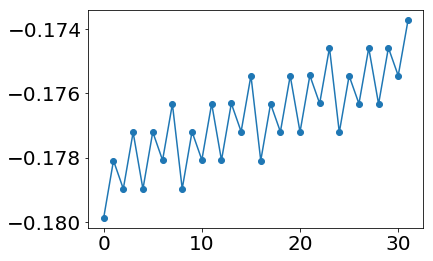

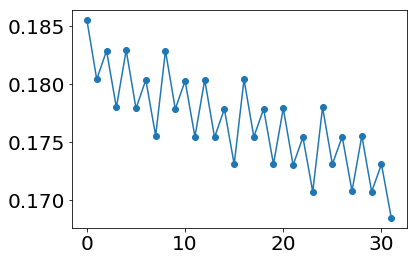

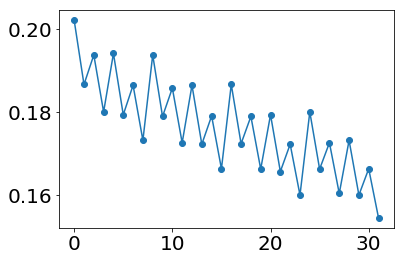

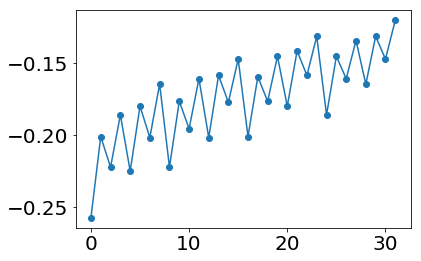

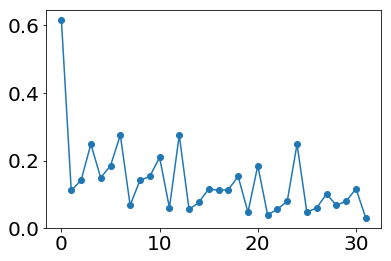

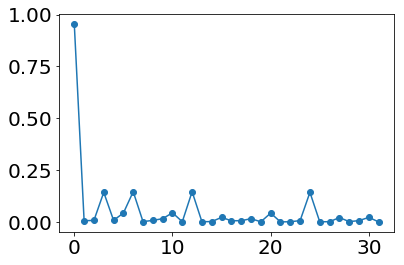

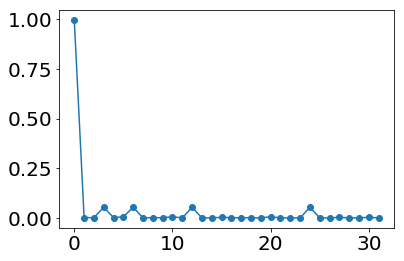

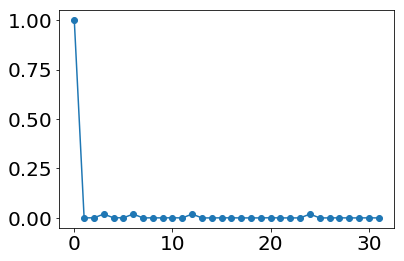

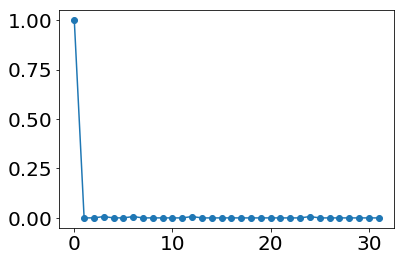

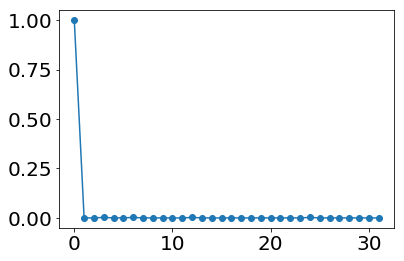

In [34]:
for wf in wf_list:
    
    plt.figure()
    plt.plot(wf, 'o-')

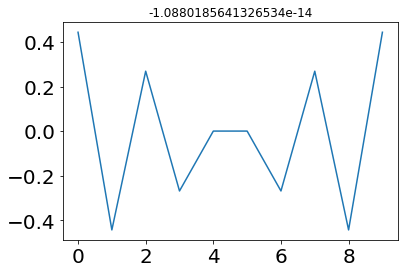

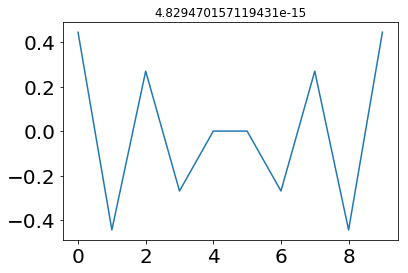

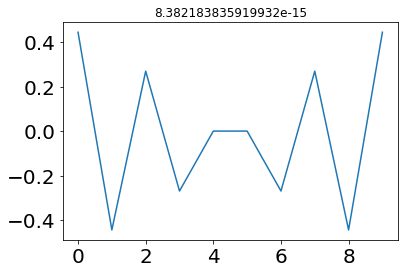

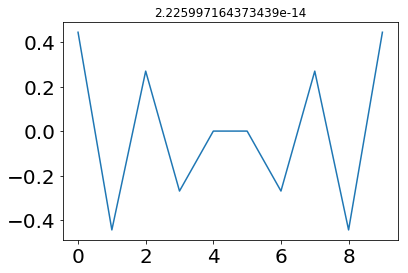

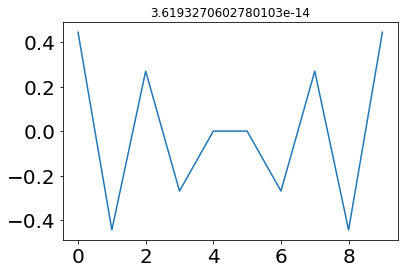

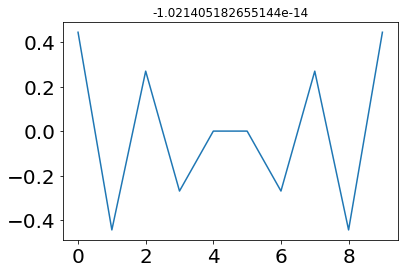

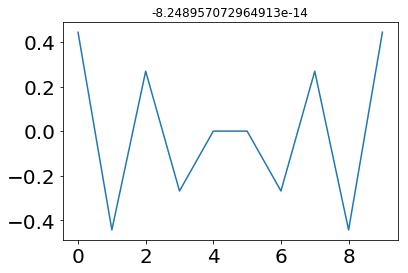

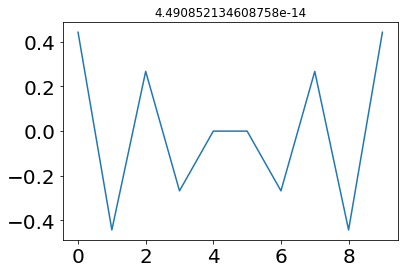

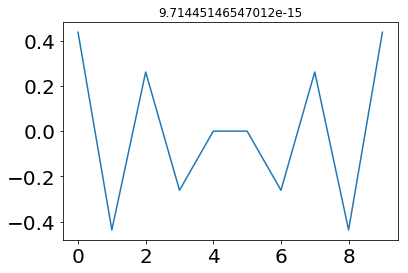

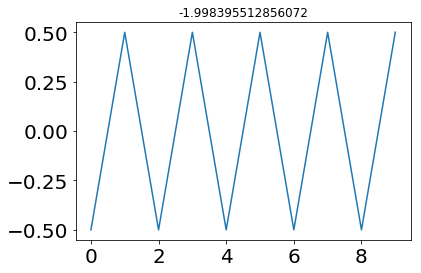

In [46]:
L = 10
psi_array = np.load('data/BH_MPS_L%.0f.npy' %L, allow_pickle=True)

V_list = np.logspace(-2,2,10)
deltat_list = np.linspace(-1,1,10)

ES_array = []
parity_array = []
dd_array = []

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    i = 9
        
    psi = psi_list[i]

    ES = psi.entanglement_spectrum()[int(L/2)]
    dES = -np.sum(ES[::2])+np.sum(ES[1::2])
    ES_list.append(dES)

    #dd = np.sum(abs(psi.expectation_value('dN')[3:L-3]))
    dd = 0
    for i in np.arange(3, L-3):
        dd += (-1)**i*psi.expectation_value('dN')[i]
    plt.figure()
    plt.plot(psi.expectation_value('dN'))
    plt.title(dd)
    dd_list.append(dd)
